In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# !kaggle datasets download -d ninzaami/loan-predication

In [11]:
# !unzip /content/loan-predication.zip -d /content/drive/MyDrive/LoanPredication

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from datetime import datetime
import tensorflow as tf

warnings.filterwarnings("ignore")
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
df = pd.read_csv('/content/drive/MyDrive/LoanPredication/train_u6lujuX_CVtuZ9i (1).csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Preprocessing

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Data Cleaning

In [15]:
null_counts = df.isnull().sum()
print(null_counts)

null_cols = null_counts[null_counts > 0].index.tolist()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [16]:
def fill_mode(column):
  df[column] = df[column].fillna(df[column].mode()[0])

df[null_cols] = df[null_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [17]:
null_counts = df.isnull().sum()
print(null_counts)

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [18]:
df.replace({"Loan_Status":{'N':0,'Y':1}},inplace=True)

In [19]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [20]:
Loan_Status_count = df['Loan_Status'].value_counts()
print(Loan_Status_count)

1    422
0    192
Name: Loan_Status, dtype: int64


## Data Visualization

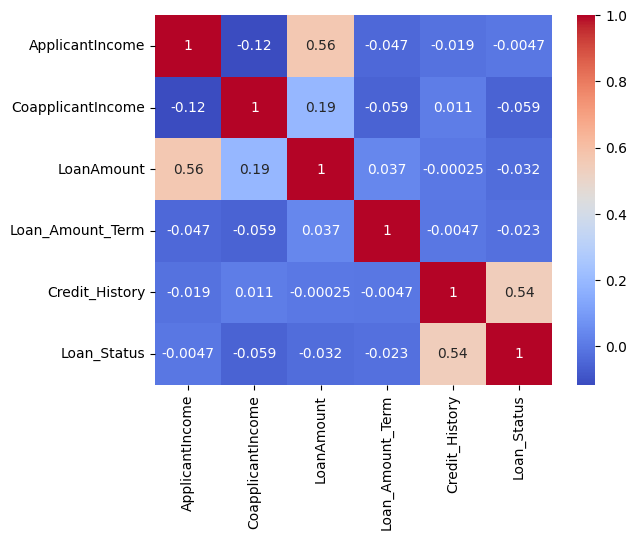

In [21]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Data preparation pipeline

In [22]:
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df['Loan_Status']

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
t = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols), ('num', MinMaxScaler(), numeric_cols)]
col_transform = ColumnTransformer(transformers=t)
col_transform

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')),
                                ('num', MinMaxScaler(),
                                 Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object'))])

In [24]:
print(categorical_cols)
print(numeric_cols)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    auc = roc_auc_score(y, y_hat)

    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))
    print("auc Score: {:.2f}".format(auc))
    
    return accuracy, precision, recall, f1

## Training

In [38]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb = XGBClassifier()

xgb_pipe = Pipeline(steps=[('prep',col_transform), ('model',xgb)])
xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)
print('xgb', evaluate_model(y_pred_xgb, y_test))

Accuracy: 0.76
Precision: 0.86
Recall: 0.81
F1 Score: 0.83
auc Score: 0.72
xgb (0.7642276422764228, 0.8588235294117647, 0.8111111111111111, 0.8342857142857144)


In [40]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier()

param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.05, 0.5],
    'model__max_depth': [3, 4, 5, 6, 7, 8],
    'model__n_estimators': [100, 200, 150, 300],
    'model__reg_lambda': [0.1, 1, 5, 10]
}
xgb_pipe = Pipeline(steps=[('prep',col_transform), ('model',xgb)])
grid_search = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 2 folds for each of 384 candidates, totalling 768 fits
Best parameters:  {'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__reg_lambda': 10}
Best score:  0.8106437697030031


In [41]:
xgb_tuned = XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=200, reg_lambda=10)

xgb_tuned_pipe = Pipeline(steps=[('prep',col_transform), ('model',xgb_tuned)])
xgb_tuned_pipe.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_tuned_pipe.predict(X_test)
print('xgb_tuned', evaluate_model(y_pred_xgb_tuned, y_test))
print(xgb_tuned_pipe.score(X_test, y_test))

Accuracy: 0.81
Precision: 0.99
Recall: 0.79
F1 Score: 0.88
auc Score: 0.87
xgb_tuned (0.8130081300813008, 0.9882352941176471, 0.7924528301886793, 0.8795811518324608)
0.8130081300813008


In [ ]:
from joblib import dump

dump(xgb_tuned_pipe, 'loan_predication.pkl')

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
rf_pipe = Pipeline(steps=[('perp', col_transform), ('model', rf)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print('rf', evaluate_model(y_pred_rf, y_test))
print(rf_pipe.score)

Accuracy: 0.81
Precision: 0.99
Recall: 0.79
F1 Score: 0.88
auc Score: 0.87
rf (0.8130081300813008, 0.9882352941176471, 0.7924528301886793, 0.8795811518324608)
<bound method Pipeline.score of Pipeline(steps=[('perp',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=3, random_state=42))])>


In [44]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'model__max_depth': [3, 4, 5, 6, 7, 8],
    'model__n_estimators': [100, 200, 150, 300],
}
xgb_pipe = Pipeline(steps=[('prep',col_transform), ('model',rf)])
grid_search = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best parameters:  {'model__max_depth': 3, 'model__n_estimators': 100}
Best score:  0.8086029533764725


In [47]:
from sklearn.ensemble import BaggingClassifier

rf = BaggingClassifier( random_state=42)
rf_pipe = Pipeline(steps=[('perp', col_transform), ('model', rf)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print('rf', evaluate_model(y_pred_rf, y_test))
print(rf_pipe.score)

Accuracy: 0.68
Precision: 0.76
Recall: 0.77
F1 Score: 0.77
auc Score: 0.63
rf (0.6829268292682927, 0.7647058823529411, 0.7738095238095238, 0.7692307692307693)
<bound method Pipeline.score of Pipeline(steps=[('perp',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object'))])),
                ('model', BaggingClassifier(random_state=42))])>


In [48]:
from sklearn.linear_model import PassiveAggressiveClassifier

rf = PassiveAggressiveClassifier( random_state=42)
rf_pipe = Pipeline(steps=[('perp', col_transform), ('model', rf)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print('rf', evaluate_model(y_pred_rf, y_test))
print(rf_pipe.score)

Accuracy: 0.54
Precision: 0.36
Recall: 0.91
F1 Score: 0.52
auc Score: 0.65
rf (0.5365853658536586, 0.36470588235294116, 0.9117647058823529, 0.5210084033613446)
<bound method Pipeline.score of Pipeline(steps=[('perp',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object'))])),
                ('model', PassiveAggressiveClassifier(random_state=42))])>


In [49]:
from sklearn.svm import SVC

rf = SVC(random_state=42)
rf_pipe = Pipeline(steps=[('perp', col_transform), ('model', rf)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print('rf', evaluate_model(y_pred_rf, y_test))
print(rf_pipe.score)

Accuracy: 0.81
Precision: 0.99
Recall: 0.79
F1 Score: 0.88
auc Score: 0.87
rf (0.8130081300813008, 0.9882352941176471, 0.7924528301886793, 0.8795811518324608)
<bound method Pipeline.score of Pipeline(steps=[('perp',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object'))])),
                ('model', SVC(random_state=42))])>


In [52]:
svm = SVC()

svm_pipe = Pipeline(steps=[('prep', col_transform), ('model', svm)])
param_grid = {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf', 'poly'], 'model__gamma': ['scale', 'auto']}
grid_search = GridSearchCV(svm_pipe, param_grid, cv=2, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END model__C=0.1, model__gamma=scale, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.1, model__gamma=scale, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time=   0.0s
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time=   0.0s
[CV] END model__C=0.1, model__gamma=scale, model__kernel=poly; total time=   0.0s
[CV] END model__C=0.1, model__gamma=scale, model__kernel=poly; total time=   0.0s
[CV] END model__C=0.1, model__gamma=auto, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.1, model__gamma=auto, model__kernel=linear; total time=   0.0s
[CV] END .model__C=0.1, model__gamma=auto, model__kernel=rbf; total time=   0.0s
[CV] END .model__C=0.1, model__gamma=auto, model__kernel=rbf; total time=   0.0s
[CV] END model__C=0.1, model__gamma=auto, model__kernel=poly; total time=   0.0s
[CV] END model__C=0.1, model__gamma=